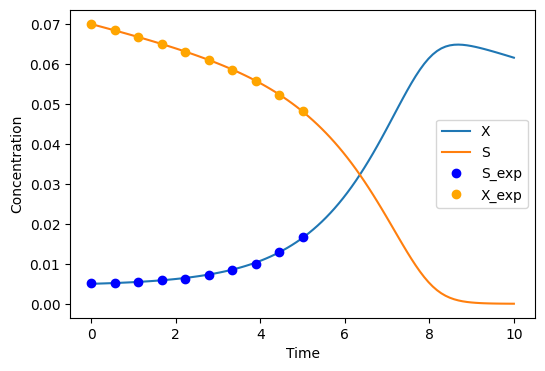

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint


# Define the ODE system
def ode_func(t, y):
    # y: array of dependent variables
    # Define the ODEs here
    X = y[0]
    S = y[1]
    mu_max = 0.86
    Ks = 0.0138
    Y_XS = 1.28
    kd = 3.3e-3
    mu = mu_max * S / (S + Ks)
    dydt = [mu * X - kd, -1/Y_XS * mu * X]
    return dydt


# Set initial conditions
y0 = [0.005, 0.07]

# Set the time grid
t_span = [0, 10]
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Solve the ODE system
sol = solve_ivp(ode_func, t_span, y0, method='RK45', t_eval=t_eval)

# Make training data
t_train = np.linspace(t_span[0], 5, 10)
y_train = solve_ivp(ode_func, [0,5], y0, method='RK45', t_eval=t_train)
y_train.y = y_train.y + np.random.normal(0, 0.0001, y_train.y.shape)

# Plot the results
plt.figure(figsize=(6,4))
plt.plot(sol.t, sol.y[0], label='X')
plt.plot(sol.t, sol.y[1], label='S')
plt.plot(y_train.t, y_train.y[0], 'o', color='blue', label='S_exp')
plt.plot(y_train.t, y_train.y[1], 'o', color='orange', label='X_exp')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

t_train = torch.tensor(y_train.t, dtype=torch.float32).reshape(-1, 1)
y_train = torch.tensor(y_train.y, dtype=torch.float32).T

In [58]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(1, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = NN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def phys_loss(model):
    t_train = torch.linspace(4, 10, 100).reshape(-1,1)
    t_train.requires_grad = True
    y_h = model(t_train)
    y_h_A = y_h[:,0]
    y_h_B = y_h[:,1]
    dy_h_A_dt = torch.autograd.grad(y_h_A, t_train, create_graph=True)[0]
    dy_h_B_dt = torch.autograd.grad(y_h_B, t_train, create_graph=True)[0]    
    error_A = dy_h_A_dt - (0.86 * y_h_A / (y_h_B + 0.0138) - 3.3e-3 * y_h_A)
    error_B = dy_h_B_dt - (-1/1.28 * model(t_train)[:,0] * model(t_train)[:,1])
    return torch.mean(error_A**2) + torch.mean(error_B**2)
    
for i in range(10000):
    optimizer.zero_grad()
    y_pred = model(t_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Epoch {i}, Loss: {loss.item()}')

In [73]:
y_[:,1]

tensor([0.0701, 0.0697, 0.0692, 0.0688, 0.0684, 0.0680, 0.0702, 0.0697, 0.0693,
        0.0688, 0.0683, 0.0678, 0.0674, 0.0669, 0.0664, 0.0660, 0.0655, 0.0650,
        0.0646, 0.0641, 0.0636, 0.0632, 0.0627, 0.0622, 0.0617, 0.0613, 0.0608,
        0.0603, 0.0599, 0.0594, 0.0589, 0.0585, 0.0580, 0.0575, 0.0570, 0.0566,
        0.0561, 0.0556, 0.0552, 0.0547, 0.0542, 0.0538, 0.0533, 0.0528, 0.0523,
        0.0519, 0.0514, 0.0509, 0.0505, 0.0500, 0.0495, 0.0491, 0.0489, 0.0494,
        0.0500, 0.0506, 0.0511, 0.0517, 0.0523, 0.0528, 0.0534, 0.0540, 0.0545,
        0.0551, 0.0557, 0.0562, 0.0568, 0.0574, 0.0579, 0.0585, 0.0591, 0.0597,
        0.0602, 0.0608, 0.0614, 0.0619, 0.0625, 0.0631, 0.0636, 0.0642, 0.0648,
        0.0653, 0.0659, 0.0665, 0.0670, 0.0676, 0.0682, 0.0687, 0.0693, 0.0699,
        0.0705, 0.0710, 0.0716, 0.0722, 0.0727, 0.0733, 0.0739, 0.0744, 0.0750,
        0.0756], grad_fn=<SelectBackward0>)

In [68]:
t_train = torch.linspace(0, 10, 100).reshape(-1,1)
t_train.requires_grad = True
y_ = model(t_train)
torch.autograd.grad(y_, t_train, torch.ones_like(y_), create_graph=True)[0].shape


torch.Size([100, 1])

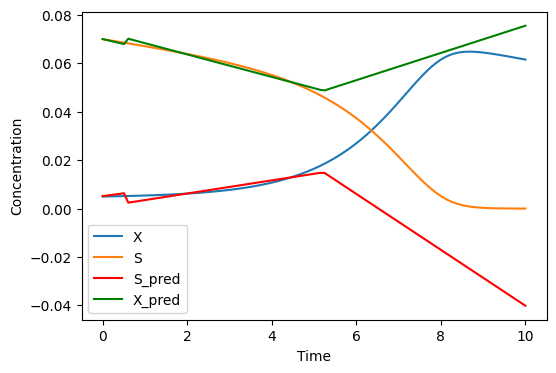

In [57]:
t_test = torch.linspace(0, 10, 100).reshape(-1, 1)
y_h = model(t_test).detach().numpy()

plt.figure(figsize=(6,4))
plt.plot(sol.t, sol.y[0], label='X')
plt.plot(sol.t, sol.y[1], label='S')
plt.plot(t_test, y_h[:,0], color='red', label='S_pred')
plt.plot(t_test, y_h[:,1], color='green', label='X_pred')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()